# Data Mining – Recherche des thèmes


---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import datetime
import warnings
import re

from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import spacy

warnings.simplefilter("ignore", DeprecationWarning)

In [2]:
df = pd.read_csv("data/data_cleaned.csv", index_col=0)
df.reset_index(drop=True,inplace=True)

In [3]:
df.head(2)

,url,shares,cleaned_article,author_name,title,nb_images,num_videos,num_hrefs,num_keywords,chanel,date,day,week
0,http://mashable.com/2013/01/07/ap-samsung-spon...,711,The Associated Press is the latest news organ...,Seth Fiegerman,AP's Twitter to Begin Displaying Sponsored Tweets,1,0.0,3.0,4.0,Business,2013-01-07,Monday,0
1,http://mashable.com/2013/01/07/apple-40-billio...,1500,It looks like 2012 was a pretty good year for...,Seth Fiegerman,Apple's App Store Passes 40 Billion Downloads,1,0.0,3.0,6.0,Business,2013-01-07,Monday,0


## 1 – Pré-traitement

Tout d'abord, il faut mettre en forme nos données textuelles. Pour cela, plusieurs étapes doivent être faites : 

1 – La **tokenisation** est l'acte de décomposer une séquence de chaînes de caractères en morceaux tels que des mots, des mots-clés, des phrases, des symboles et d'autres éléments appelés **tokens**. Lors du processus de tokenisation, certains caractères comme les signes de ponctuation sont éliminés et le texte en transformé en minuscule. Pour notre cas, le processus de **tokenisation**, permet de créer une liste de chaque mot présent dans un article, de lui retirer sa ponctuation, ses stopwords, et prendre en compte les mots composés en tant que token unique.

2 – Le **stemming** est le processus de réduction d'un mot à sa racine.
L'avantage de ce procédé est que nous pouvons réduire le nombre total de mots uniques dans le dictionnaire. Par conséquent, le nombre de colonnes de la matrice documents–termes contiendra moins de colonnes.

$$\text{ou}$$

2 – La **lemmatisation** est une méthode de conversion d'un mot en sa forme de base. La différence avec le stemming est qu'elle tient compte du contexte et convertit le mot dans une forme compréhensible, alors que le stemming ne fait que supprimer les derniers caractères, ce qui entraîne souvent des significations incorrectes et pouvant rassembler des mots complètement différents. 


Pour notre cas, nous choisissons de d'utiliser la lemmatisation, car le sens des mots est important pour la détection des thèmes latents.

In [4]:
sp = spacy.load("en_core_web_lg")
merge_ents = sp.create_pipe("merge_entities")
sp.add_pipe(merge_ents)

spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS

On peut choisir des mots à ajouter comme `stopword`

In [5]:
add = ["mashable", "image", "courtesy", 'photo', "say"]
spacy_stopwords.update(add)

La fonction suivante permet d'appliquer le preprocessing et faire ressortir les tokens sous forme d'une liste. Les fonctions `join` et `split` seront utiles pour la suite pour donner plusieurs formes aux tokens retenus.

In [6]:
def hasNumbers(inputString):
    return bool(re.search(r'\d', inputString))

In [7]:
def lemma(document, stopwords=spacy.lang.en.stop_words.STOP_WORDS):  
    
    select = [word.lemma_.lower() for word in sp(document) 
              if not hasNumbers(str(word.lemma_))
              and word.lemma_ not in ["-PRON-"] 
              and word.lemma_.lower() not in stopwords 
              and len(word.text) > 2]
    
    return select

In [8]:
def join(document):
    return ','.join(document)

In [9]:
def hasproblem(inputString):
    return bool(re.search('[a-zA-Z].*', inputString))

In [10]:
def split(document):
    liste = document.split(",")
    return [i.replace('\"','').replace("#",'').replace("\'",'').strip() for i in liste if hasproblem(i)]

On applique la fonction : 

In [11]:
%%time

serie = df.cleaned_article.apply(lambda x : lemma(x,stopwords=spacy_stopwords))

CPU times: user 1h 38min 20s, sys: 6min 52s, total: 1h 45min 13s
Wall time: 58min 58s


In [12]:
serie.head(2)

0    [the associated press, late, news, organizatio...
1    [look, like, a pretty good year, apple, app, s...
Name: cleaned_article, dtype: object

In [13]:
serie_text = serie.apply(lambda x : join(x))

In [14]:
serie_text.head(2)

0    the associated press,late,news,organization,ex...
1    look,like,a pretty good year,apple,app,store,a...
Name: cleaned_article, dtype: object

## 2 – Bag of word 

Il s'agit de calculer le nombre d'occurrences de chaque terme dans le document considéré (on parle de « fréquence » par abus de langage). Plusieurs variantes existent : un choix simple, dit « binaire », est de mettre 1 si le terme apparaît dans le document et 0 sinon. À l'opposé, on peut normaliser logarithmiquement la fréquence brute pour amortir les écarts.

Ici, on a choisi deux méthodes pour afficher la matrice des documents-termes : 

- La première utilise **la fréquence brute** (nombre d'occurence de chaque mot pour le texte considéré). Pour notre exemple, on a 10 000 documents et 114 365 mots différents.  Il s'agit donc d'un simple comptage des mots pour le document.

- La seconde utilise **TF-IDF**. Cela consiste à multiplier TF (nombre d'occurence sur le nombre total de mot) avec IDF : la fréquence inverse de document (inverse document frequency). Il s'agit d'une mesure de l'importance du terme dans l'ensemble du corpus. Dans le schéma TF-IDF, cette méthode vise à donner un poids plus important aux termes les moins fréquents, considérés comme plus discriminants. Elle consiste à calculer le logarithme de l'inverse de la proportion de documents du corpus qui contiennent ce terme.

---
_Note : Est-ce qu'on met comme argument : `max_df=0.95, min_df=0.05, max_features=1000` ?_ :  

> `max_feature` : cela permet de limiter le nombre mots à prendre en compte dans le vocabulaire. Par exemple, on prend les 100 premiers mots les plus utilisés.

> `max_df` est utilisé pour supprimer les termes qui apparaissent trop fréquemment.

> `min_df` est utilisé pour supprimer les termes qui n'apparaissent que trop rarement, également appelés "mots spécifiques au corpus".

Pour ces arguments, on spécifie soit en % de documents, soit en nombre. 

---

Le premier Bag of Word que nous utiliserons ne contiendra que 100 mots afin de faciliter la visualisation.

### Bag of word : TF-IDF

In [15]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.90, min_df=0.01, 
                                   max_features=100, tokenizer=split)
tfidf = tfidf_vectorizer.fit_transform(serie_text)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

In [16]:
tfidf.shape

(38405, 100)

### Bag of word : TF

In [18]:
tf_vectorizer = CountVectorizer(stop_words='english', max_df=0.90, min_df=0.01, 
                                max_features=100, tokenizer=split)
tf = tf_vectorizer.fit_transform(serie_text)
tf_feature_names = tf_vectorizer.get_feature_names()

In [21]:
tf.shape

(38405, 100)

## 3 – Visualisation : l'embedding des mots

In [19]:
def get_word_vectors(words):
    return [sp(word).vector for word in words]

In [20]:
words = tf_feature_names
embedding = np.array(get_word_vectors(words))

Maintenant qu'on possède notre matrice à très grande dimension (38 000 x 100), on peut comparer les mots se trouvant à une distance proche. 



Une technique pour visualiser l'embedding des mots est de transformer chacun des mots dans un corpus comme un vecteur. Pour cela, nous utilisons une librairie déjà entraînée avec un algorithme de Word2vec. Celui-ci consiste à attribuer pour chaque mot un vecteur de dimension 300.

Pour notre visualisation, nous utiliserons les mots uniques conservés par le Bag of Words prédédents. L'option `max_features` permet de définir un nombre maximal de mots (les plus récurrents) pour visualiser le corpus graphiquement.

Lorsque nous transformons l'ensemble des mots les plus importants du Bag of Word et nous les transformons, nous nous retrouvons avec une matrice de dimensions : 100 x 300. Ce type de matrice est donc visuellement difficile à afficher. Pour cela, nous décidons d'utilsier une méthode de réduction de dimensions afin de conserver les deux premières composantes et afficher les mots sur un graphique.

### ACP

Une manière simple de réduire la dimension est d'utiliser la méthode de l'Analyse en Composante Principale.

In [21]:
pca = PCA(n_components=2)
pca.fit(embedding)

word_vecs_2d = pca.transform(embedding)

Pour améliorer la visualisation, nous pouvons utiliser un algorithme de clustering pour faire ressortir les groupes de mots les plus proches (en termes d'usage). La méthode que nous décidons d'utiliser reste la plus simple : le K-Mean. Toutefois, il convient de trouver le nombre de cluster optimal. Pour cela, nous utilisons le critère du coude pour choisir ce nombre de clusters (qui ne correpsond pas au nombre de thème, mais seulement pour observer les groupes de mots avec un sens proche).

In [22]:
inertia_ = []
labels = []

for i in range(1,20):
    kmean = KMeans(n_clusters=i)
    kmean.fit(word_vecs_2d)
    inertia_.append(kmean.inertia_)
    labels.append(kmean.labels_)

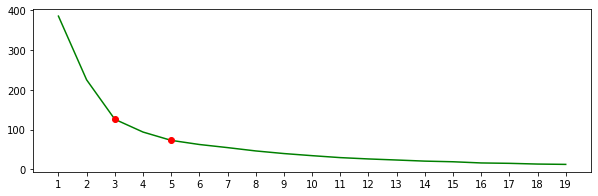

In [24]:
plt.figure(figsize=(10,3))
plt.plot(np.arange(1,20),inertia_, c='g')
plt.xticks(np.arange(1,20));
plt.scatter(3,inertia_[2],c='r', zorder=3)
plt.scatter(5,inertia_[4],c='r', zorder=3);
plt.savefig("kchoice.png")

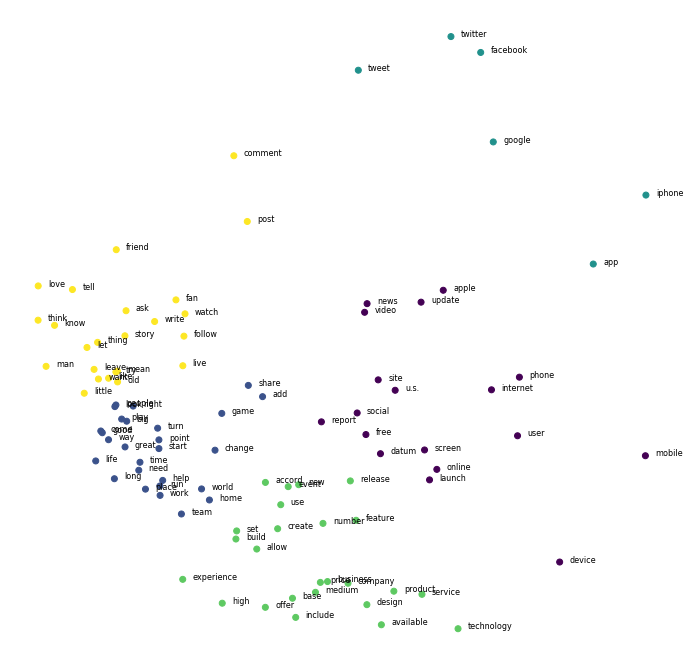

In [25]:
plt.figure(figsize=(12,12))
plt.scatter(word_vecs_2d[:,0], word_vecs_2d[:,1], c=labels[4])

for word, coord in zip(words, word_vecs_2d):
    x, y = coord
    plt.text(x + 0.1, y, word,size = 8)
plt.axis(False)
plt.savefig("acp.png");

### t-SNE


On peut également utiliser **l'algorithme t-SNE** (distributed stochastic neighbor embedding). Il s'agit d'une technique de réduction de dimension pour la visualisation de données. Elle consiste à réduire en deux ou trois dimensions une matrice à grande dimensionnalité. Ainsi, si deux points sont proches (resp. éloignés) dans l'espace d'origine ils devront être proches (resp. éloignés) dans l'espace à faible dimension. Pour le faire, cet algorithme se base sur une probabilité des proximités de chacun des points.

In [26]:
mani = TSNE(n_components=2)
word_vecs_2d = mani.fit_transform(embedding)

Pour améliorer la visualisation, on peut utiliser encore une fois un algorithme de clustering.

In [27]:
kmean = KMeans(n_clusters=5)
color = kmean.fit_predict(word_vecs_2d)

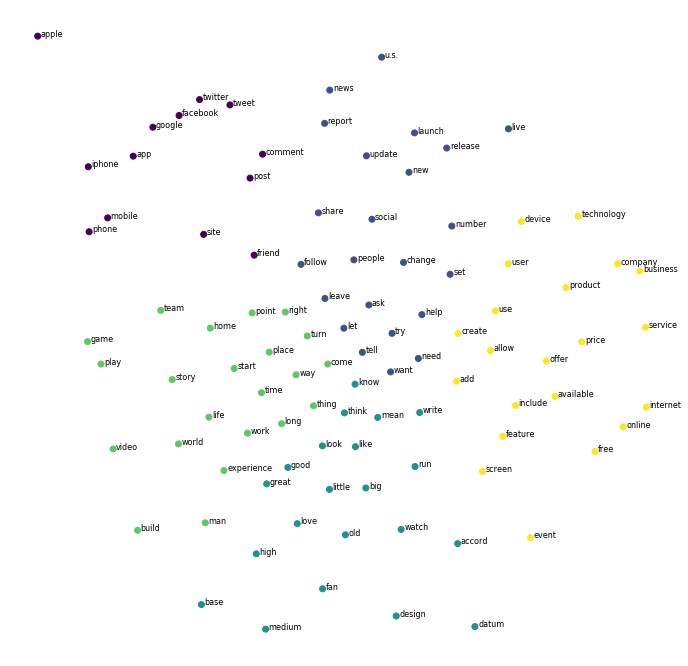

In [29]:
plt.figure(figsize=(12,12))
plt.scatter(word_vecs_2d[:,0], word_vecs_2d[:,1], c=color)

for word, coord in zip(words, word_vecs_2d):
    x, y = coord
    plt.text(x + 0.5 , y, word,size = 8)
plt.axis(False)
plt.savefig('tsne.png');

## 4 – Recherche des thèmes 

Nous pouvons revenir à notre objectif principale : la détection des thèmes latents.

On utilise deux algorithmes : 

- **Latent Dirichlet Allocation (LDA)** : Il s'agit d'un modèle de type génératif permettant d’expliquer des ensembles d’observations, par le moyen de groupes non observés. Ces derniers sont définis par des similarités entre les données. Par exemple, si les observations sont les mots collectés dans un ensemble de documents textuels, le modèle LDA suppose que chaque document est un mélange d’un petit nombre de sujets et que la génération de chaque occurrence d’un mot est attribuable (en termes de probabilité) à l’un des thèmes du document.


- **Non-négative Matrix Factorization (NMF)** : Il s'agit d'une technique de factorisation de matrice par la décomposition en valeur singulière (comme pour l'ACP). C'est donc une technique de réduction de dimension mais les composantes sont non-orthogonales (contrairement à l'ACP). Elle est adaptée aux matrices creuses (matrice de grandes dimensions contenant beaucoup de 0) ne contenant que des données positives, par exemple des occurrences de mots. Le fait que les facteurs de décomposition n’étant pas orthogonaux, des superpositions peuvent apparaître : des même mots participants à plusieurs thèmes. Lee et Seung (1999) illustre cette méthode sur la classification d’un corpus de 30991 articles de l’encyclopédie Grolier. Plutôt que de classer ces articles par thèmes choisis a priori, ils sont classés sur la base d’un vocabulaire de 15 276 mots.

On retire l'option de max feature pour améliorer la prédiction des thèmes

### Bag of word : TF-IDF

In [30]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=0.01, tokenizer=split)
tfidf = tfidf_vectorizer.fit_transform(serie_text)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

### Bag of word : TF

In [31]:
tf_vectorizer = CountVectorizer(stop_words='english', max_df=0.95, min_df=0.01, tokenizer=split)
tf = tf_vectorizer.fit_transform(serie_text)
tf_feature_names = tf_vectorizer.get_feature_names()

### Modèles

La technique de GridSearchCV plus basse nous à permit de trouver le nombre de thèmes suivant : 

In [32]:
n_topics_tf = 16
n_topics_tfidf = 5

Pour la matrice TF

In [33]:
nmf = NMF(n_components=n_topics_tf, random_state=1, alpha=.1, 
          l1_ratio=.5, init='nndsvd')

lda = LatentDirichletAllocation(n_components=n_topics_tf, max_iter=10, 
                                learning_method='online', 
                                learning_offset=50,random_state=1)

In [34]:
%%time

nmf.fit(tf)
lda.fit(tf)

CPU times: user 10min 55s, sys: 5.61 s, total: 11min 1s
Wall time: 5min 37s


LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=50,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=16, n_jobs=None,
                          perp_tol=0.1, random_state=1, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

Pour la matrice TF-IDF

In [35]:
nmf2 = NMF(n_components=n_topics_tfidf, random_state=1, alpha=.1, 
          l1_ratio=.5, init='nndsvd')

lda2 = LatentDirichletAllocation(n_components=n_topics_tfidf, max_iter=10, 
                                learning_method='online', 
                                learning_offset=50,random_state=1)

In [36]:
%%time

nmf2.fit(tfidf)
lda2.fit(tfidf)

CPU times: user 5min 14s, sys: 2.2 s, total: 5min 16s
Wall time: 2min 40s


LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=50,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=5, n_jobs=None,
                          perp_tol=0.1, random_state=1, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

---

### Choix du nombre de thèmes

_Note : ne pas lancer car long en calcul_

On souhaite trouver le nombre optimal de thème. On va donc utiliser la fonction GridSearchCV. Ainsi, on va comparer le modèle LDA pour les deux types de matrice de Bag of Word.

In [16]:
search_params = {'n_components': list(range(3,20))} 

model_tfidf_lda = GridSearchCV(lda2, param_grid=search_params, cv=3)
model_tfidf_lda.fit(tfidf)

model_tf_lda = GridSearchCV(lda, param_grid=search_params, cv=3)
model_tf_lda.fit(tf)

GridSearchCV(cv=3, error_score=nan,
             estimator=LatentDirichletAllocation(batch_size=128,
                                                 doc_topic_prior=None,
                                                 evaluate_every=-1,
                                                 learning_decay=0.7,
                                                 learning_method='online',
                                                 learning_offset=50,
                                                 max_doc_update_iter=100,
                                                 max_iter=10,
                                                 mean_change_tol=0.001,
                                                 n_components=10, n_jobs=None,
                                                 perp_tol=0.1, random_state=1,
                                                 topic_word_prior=None,
                                                 total_samples=1000000.0,
                                   

In [17]:
lda_tfidf = pd.DataFrame(model_tfidf_lda.cv_results_)
lda_tf = pd.DataFrame(model_tf_lda.cv_results_)

resultats = pd.concat([lda_tf,lda_tfidf])

In [18]:
resultats[resultats.rank_test_score == 1]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_components,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
13,61.131920,0.98625,2.926447,0.029464,16,{'n_components': 16},-2.378221e+06,-2.461627e+06,-2.261597e+06,-2.367148e+06,82036.668711,1
0,44.103827,0.81713,2.182995,0.073621,3,{'n_components': 3},-2.252220e+05,-2.238945e+05,-2.221163e+05,-2.237443e+05,1272.355670,1


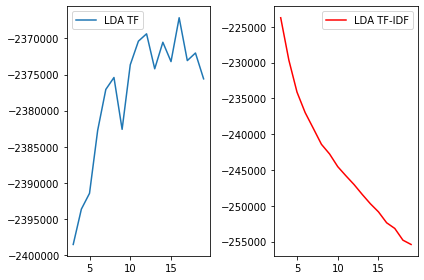

In [19]:
plt.subplot(121)
plt.plot(lda_tf.param_n_components,lda_tf.mean_test_score,label='LDA TF')
plt.legend();
plt.subplot(122)
plt.plot(lda_tf.param_n_components,lda_tfidf.mean_test_score, label='LDA TF-IDF',c='r')
plt.legend();
plt.tight_layout()

---

La fonction ci-dessous permet d'afficher les thèmes et les mots associés pour ce thème.

In [38]:
def topics(vectorizer, model, n_words=10):
    keywords = np.array(vectorizer.get_feature_names())
    
    topic_keywords = []
    
    for topic_weights in model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    
    return topic_keywords

On spécifie le nombre de thème, le vectorizer pour récupérer le vocabulaire ainsi que l'algorithme.

In [83]:
topic_keywords = topics(tfidf_vectorizer, lda2, n_words=10)

df_topic_keywords = pd.DataFrame(topic_keywords)

df_topic_keywords.columns = ['Word '+ str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+ str(i) for i in range(df_topic_keywords.shape[0])]

df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9
Topic 0,police,government,people,report,country,accord,city,u.s.,state,ukraine
Topic 1,company,facebook,user,twitter,social,google,service,app,new,use
Topic 2,film,movie,trailer,episode,netflix,character,star,series,disney,premiere
Topic 3,app,apple,device,iphone,new,phone,use,android,user,samsung
Topic 4,video,game,like,time,youtube,fan,good,know,love,song


In [42]:
lda2_topics = {"0":"Politics and diplomacy", 
 "1":"Internet and social media",
 "2":"Videos and movies",
"3":"Telecomunication devices",
'4':"Entertainment"}

In [84]:
topic_keywords = topics(tfidf_vectorizer, nmf, n_words=10)

df_topic_keywords2 = pd.DataFrame(topic_keywords)

df_topic_keywords2.columns = ['Word '+str(i) for i in range(df_topic_keywords2.shape[1])]
df_topic_keywords2.index = ['Topic '+str(i) for i in range(df_topic_keywords2.shape[0])]

df_topic_keywords2

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9
Topic 0,like,time,people,know,think,want,work,way,thing,good
Topic 1,child,age,mother,number,job,mom,thing,like,good,moment
Topic 2,app,ios,user,android,new,free,update,available,mobile,feature
Topic 3,use,user,site,create,file,email,web,design,allow,work
Topic 4,game,play,player,new,fan,character,world,time,team,console
Topic 5,apple,iphone,new,event,california,ipad,ios,tim cook,product,san francisco
Topic 6,u.s.,report,country,accord,president,state,people,government,official,russia
Topic 7,twitter,tweet,social,account,medium,user,follow,new,news,post
Topic 8,facebook,user,social,post,friend,people,page,like,network,share
Topic 9,phone,device,screen,new,tablet,camera,smartphone,samsung,display,design


In [123]:
nmf_topic = {"0":"other",
"1":"family and job",
"2":"devices telecomunication1",
"3":"web",
"4":"sport and gaming1",
"5":"apple",
"6":"politics and society1",
"7":"twitter",
"8":"facebook",
"9":"devices telecomunication2",
"10":"musics and videos",
"11":"sport and gaming2",
"12":"photography",
"13":"politics and society2",
"14":"business",
"15":"google"}

### Attribution du thème pour chaque document

Mise en place du score de chaque document à la ressemblance d'un thème.

In [118]:
def color_green(val):
    color = "green" if val > .1 else "black"
    return "color: {col}".format(col=color)

In [119]:
def make_bold(val):
    weight = 700 if val > .1 else 400
    return "font-weight: {weight}".format(weight=weight)

In [124]:
lda_output = nmf.transform(tf)
topicnames = ["Topic_nmf " + str(nmf_topic[str(i)]) for i in range(nmf.n_components)]
docnames = [i for i in range(len(serie))]


df_document_topic = pd.DataFrame(np.round(lda_output, 3), columns=topicnames, index=docnames)

dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic["dominant_topic"] = dominant_topic

In [125]:
df_document_topic

,Topic_nmf other,Topic_nmf family and job,Topic_nmf devices telecomunication1,Topic_nmf web,Topic_nmf sport and gaming1,Topic_nmf apple,Topic_nmf politics and society1,Topic_nmf twitter,Topic_nmf facebook,Topic_nmf devices telecomunication2,Topic_nmf musics and videos,Topic_nmf sport and gaming2,Topic_nmf photography,Topic_nmf politics and society2,Topic_nmf business,Topic_nmf google,dominant_topic
0,0.004,0.000,0.003,0.000,0.000,0.001,0.000,0.297,0.013,0.026,0.000,0.000,0.021,0.000,0.132,0.003,7
1,0.000,0.000,0.265,0.000,0.000,0.098,0.000,0.000,0.000,0.000,0.000,0.005,0.000,0.000,0.046,0.000,2
2,0.027,0.000,0.000,0.006,0.305,0.000,0.060,0.000,0.000,0.000,0.029,0.100,0.020,0.000,0.003,0.000,4
3,0.058,0.015,0.242,0.000,0.070,0.042,0.010,0.035,0.033,0.424,0.216,0.000,0.000,0.003,0.061,0.000,9
4,0.000,0.000,0.061,0.000,0.056,0.022,0.000,0.000,0.000,0.197,0.034,0.000,0.000,0.005,0.104,0.026,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38400,0.000,0.060,0.237,0.024,0.028,0.000,0.000,0.002,0.010,0.080,0.000,0.020,0.004,0.000,0.012,0.055,2
38401,0.017,0.000,0.000,0.000,0.000,0.000,0.000,0.069,0.000,0.000,0.045,0.000,0.000,0.001,0.000,0.000,7
38402,0.007,0.014,0.029,0.000,0.000,0.006,0.003,0.000,0.001,0.000,0.143,0.000,0.004,0.003,0.000,0.000,10
38403,0.000,0.000,0.000,0.000,0.000,0.000,0.353,0.000,0.032,0.007,0.027,0.009,0.000,0.363,0.000,0.000,13


In [126]:
df_document_topic["Topic_nmf devices telecomunication"] = df_document_topic["Topic_nmf devices telecomunication1"] + df_document_topic["Topic_nmf devices telecomunication2"]
df_document_topic["Topic_nmf politics and society"] = df_document_topic["Topic_nmf politics and society1"] + df_document_topic["Topic_nmf politics and society2"]
df_document_topic["Topic_nmf sport and gaming"] = df_document_topic["Topic_nmf sport and gaming1"] + df_document_topic["Topic_nmf sport and gaming2"]

In [127]:
df_document_topic.drop(columns=["Topic_nmf devices telecomunication1", 
                                "Topic_nmf devices telecomunication2",
                               "Topic_nmf politics and society1",
                                "Topic_nmf politics and society2",
                                "Topic_nmf sport and gaming1",
                                "Topic_nmf sport and gaming2"], inplace=True)

In [128]:
nmf_topic = {"0":"other",
"1":"family and job",
"2":"devices telecomunication",
"3":"web",
"4":"sport and gaming",
"5":"apple",
"6":"politics and society",
"7":"twitter",
"8":"facebook",
"9":"devices telecomunication",
"10":"musics and videos",
"11":"sport and gaming",
"12":"photography",
"13":"politics and society",
"14":"business",
"15":"google"}

In [129]:
df_document_topic.dominant_topic = df_document_topic.dominant_topic.apply(lambda x : nmf_topic[str(x)])

In [130]:
df_document_topic

,Topic_nmf other,Topic_nmf family and job,Topic_nmf web,Topic_nmf apple,Topic_nmf twitter,Topic_nmf facebook,Topic_nmf musics and videos,Topic_nmf photography,Topic_nmf business,Topic_nmf google,dominant_topic,Topic_nmf devices telecomunication,Topic_nmf politics and society,Topic_nmf sport and gaming
0,0.004,0.000,0.000,0.001,0.297,0.013,0.000,0.021,0.132,0.003,twitter,0.029,0.000,0.000
1,0.000,0.000,0.000,0.098,0.000,0.000,0.000,0.000,0.046,0.000,devices telecomunication,0.265,0.000,0.005
2,0.027,0.000,0.006,0.000,0.000,0.000,0.029,0.020,0.003,0.000,sport and gaming,0.000,0.060,0.405
3,0.058,0.015,0.000,0.042,0.035,0.033,0.216,0.000,0.061,0.000,devices telecomunication,0.666,0.013,0.070
4,0.000,0.000,0.000,0.022,0.000,0.000,0.034,0.000,0.104,0.026,devices telecomunication,0.258,0.005,0.056
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38400,0.000,0.060,0.024,0.000,0.002,0.010,0.000,0.004,0.012,0.055,devices telecomunication,0.317,0.000,0.048
38401,0.017,0.000,0.000,0.000,0.069,0.000,0.045,0.000,0.000,0.000,twitter,0.000,0.001,0.000
38402,0.007,0.014,0.000,0.006,0.000,0.001,0.143,0.004,0.000,0.000,musics and videos,0.029,0.006,0.000
38403,0.000,0.000,0.000,0.000,0.000,0.032,0.027,0.000,0.000,0.000,politics and society,0.007,0.716,0.009


In [85]:
df.title[4]

"BeeWi's Smart Toys Put Your Smartphone in Control"

In [131]:
lda_output = lda2.transform(tfidf)
topicnames = ["Topic_lda " + str(lda2_topics[str(i)]) for i in range(lda2.n_components)]
docnames = [i for i in range(len(serie))]

df_document_topic_lda = pd.DataFrame(np.round(lda_output, 3), columns=topicnames, index=docnames)

dominant_topic_lda = np.argmax(df_document_topic_lda.values, axis=1)
df_document_topic_lda["dominant_topic_lda"] = dominant_topic_lda

In [132]:
df_document_topic_lda.dominant_topic_lda = df_document_topic_lda.dominant_topic_lda.apply(lambda x : lda2_topics[str(x)])

In [133]:
df_document_topic_lda.head()

,Topic_lda Politics and diplomacy,Topic_lda Internet and social media,Topic_lda Videos and movies,Topic_lda Telecomunication devices,Topic_lda Entertainment,dominant_topic_lda
0,0.024,0.903,0.024,0.025,0.024,Internet and social media
1,0.033,0.033,0.046,0.855,0.033,Telecomunication devices
2,0.564,0.023,0.023,0.024,0.365,Politics and diplomacy
3,0.018,0.022,0.019,0.923,0.018,Telecomunication devices
4,0.027,0.026,0.025,0.813,0.109,Telecomunication devices


In [134]:
final = pd.concat([df,df_document_topic, df_document_topic_lda], axis=1)

In [139]:
final.to_csv('final_topics.csv')

## Références

https://www.math.univ-toulouse.fr/~besse/Wikistat/pdf/st-m-explo-nmf.pdf